## Практическое задание
## Метод обратного распространения ошибки

### О задании

В этом задание вы:
* познакомитесь с методом обратного распространения ошибки 
* реализуете прямой проход и обратный проход в нейросети
* реальзуете стохастический градиентный спуск с моментов
* обучите нейросеть для классификации рукописных цифр

# Часть 1. Прямой и обратный проход нейросети

## Теоретическая часть

<p>
Метод обратного распространения ошибки — это метод обучения многослойной нейрононной сети, который впервые был открыт двумя независимыми группами исследователей в 1974 г. Этот метод определяет алгоритм эффективного вычисления градиентов параметров нейронной сети, что позволяется применить метод градиентного спуска в задачи минимизации функционала ошибки. 
</p>

Давайте рассморим M-слойную полносвязную нейронную сеть.

<img src="network.png" width="800">

На рисунке верхний индекс всегда используется для обозначения номера слоя нейросети. Рассмотрим некоторый n-ый слой, который назовем текущим. Данный слой на вход принимает
$N^{(n-1)}$, 
признаков 
$y^{(n - 1)}_i$, $i=\overline{1\mathinner {\ldotp \ldotp}N^{(n-1)}}$, 
которые являются значения выходов нейронов предыдущего слоя, и 
$y^{(n-1)}_0=1$
(смещение или bias нейрона — константа, которая рассматривается как вход нейрона для упрощения записи дальнейших вычислений). Вес нейрона, связывающий $i$'ый нейрон предыдущего слоя с $j$'ым нейроном текущего, обозначен $w^{(n)}_{ij}$. 
За 
$z_j^{(n)}=\sum_{i=0}^{N^{(n-1)}}{w_{ij}^{(n)}y_i^{(n-1)}}$, 
обозначена линейная комбинация входов и весов.
$\sigma^{(n)}_j$ 
— функция активации j'ого нейрона(так как функции активации нейронов в общем случае могут быть различны), а 
$y_j^{(n)} = \sigma_j^{(n)}(z_j^{(n)}) = \sigma_j^{(n)}(\sum_{i=0}^{N^{(n-1)}}{w_{ij}^{(n)}y_i^{(n-1)}}) $ 
— значение функции активации или выход j'ого нейрона. 

<img src="layer.png" width="800">

Резюмируем обозначения:
* $M$ - колличество слоев
* $N^{(n)}$ - колличество нейронов в $n$-ом слое
* $\{ w_{ij}^{(n)}\}$ - веса нейронов $n$-ого слоя
* $z_j^{(n)} = \sum_{i=0}^{N^{(n - 1)}}{w_{ij}^{(n)}y_i^{(n-1)}}$
* $\sigma_j^{(n)}$ - функция активации $j$-ого нейрона $n$-ого слоя
* $y_j^{(n)} = \sigma_j^{(n)}(z_j^{(n)})$ - выход $j$-ого нейрона $n$-ого слоя 

За $E(\boldsymbol{\widehat{y}}, \boldsymbol{y})$  обозначим некоторую диффенцируюмую функцию ошибки. Здесь  <br/>
$\boldsymbol{\widehat{y}} = (y_1, ..., y_{N^{(M)}})$ - значение целевой переменной,  
$\boldsymbol{y} = (y_1^{(M)}, ..., y_{N^{(M)}}^{(M)}))$ - выход нейросети. 

Давайте попробуем оценить сложность вычисление частной производной функции ошибки $E$. Предположим, что сложность вычисления частной производной функции в точке приблизительно равна сложности вычисления самой функции в точке. Пусть нейросеть имеет M полносвязных слоем по N нейронов в каждом слое. Тогда:
* $O(N)$ - cложность вычисления одного выхода одного слоя (перемножение N весов на N входов)
* $O(N^2)$ - cложность вычисления всех выходов одного слоя
* $O(M * N^2)$ - cложность вычисления функции ошибки (последовательно вычисляем выходы M слоев)
* $O(M^2 * N^4)$ - cложность частных производных функции ошибки по всем весам (всего  $O(M * N^2)$ весов)

Получается для нейросети, состоящей из одного слоя с 1000 нейронами, сложность вычисления градиента должна быть равна $O(10^{12})$. А это уже невероятно много.

Идея метода эффективного расчета градиентов заключается в том, чтобы при прямом проходе нейросети сохранить некоторые вычисленные значения, которые потом позволят быстро находить градиент.

### Вычисление градиента

Будем вычислять частные производные функции ошибки от последних слоев в первым.
Помимо частных производных 
$$\frac{\partial}{\partial w_{ij}^{(n)}} E$$ 
будем вычислять значения производных 
$$\frac{\mathrm{\partial}}{\partial y_i^{(n)}} E \quad \mathrm{и} \quad \frac{\mathrm{\partial}}{\partial z_i^{(n)}} E$$ вычисление которых является одним из ключевых моментов в алгоритме обратном распространения ошибки. 

Полезно посмотреть как аналитически выглядит вычисления выхода нейросети 
$\boldsymbol{\widehat{y}}=(y_1^{(M)}, ..., y_{N^{(M)}}^{(M)})$.:

$$ \widehat{y_j}=y_j^{(M)}=\sigma_j^{(M)}(\sum_{i=0}^{N^{(M-1)}}{w_{ij}^{(M)}\sigma_i^{(M-1)}(\sum_{k=0}^{N^{(M-2)}}{w_{ki}^{(M-1)}\sigma_k^{(M-2)}(...)})})$$

В случае однослойной нейросети, получим: 

$$ \widehat{y_j}=\sigma_j^{(1)}(\sum_{i=0}^{N^{(0)}}{w_{ij}^{(1)}x_j}),$$

двухслойной - 

$$ \widehat{y_j}=\sigma_j^{(2)}(\sum_{i=0}^{N^{(1)}}{w_{ij}^{(2)}\sigma_i^{(1)}(\sum_{k=0}^{N^{(0)}}{w_{ki}^{(1)}x_k})}).$$

**Вычисление градиента начнем с выходного слоя.** 

Вспомним как вычисляется выход:

$$ y_j^{(M)}=\sigma_j^{(M)}(z_j^{(M)})$$
$$z_j^{(M)} = \sum_{i=0}^{N^{(M-1)}}{w_{ij}^{(M)}y_i^{(M-1)}}$$

Будем последовательно вычислять:

1. $\boldsymbol{\frac{\partial E}{\partial y_j^{(M)}}}.$
Так как функция E нам известна, то мы можем вычислить частные производные этой функции по переменным 
$y_1^{(M)}, ..., y_{N^{(M)}}^{(M)}. $ 
Например, если
$$E(\boldsymbol{\widehat{y}},  \boldsymbol{y}^{(M)}) = \frac{1}{2} \| \boldsymbol{\widehat{y}} - \boldsymbol{y}^{(M)} \|_2^2 = \frac{1}{2} \sum_{j=1}^{N^{(M)}}{( \widehat{y_j} - y_j^{(M)}) ^ 2},$$ 
то
$$\frac{\partial E}{\partial y_j^{(M)}} = y_j^{(M)} - \widehat{y_j}$$
Заметим, что в этом случае частная производная $E$ по $y_j^{(M)}$ равна ошибки на объекте $x_i$.

2. $\boldsymbol{\frac{\mathrm{\partial E}}{\partial z_j^{(M)}}}.$ 
Функция ошибки 
$E = E(y_1^{(M)}, ..., y_{N^{(M)}}^{(M)}) = E(y_1^{(M)}(z_1^{(M)}), ..., y_{N^{(M)}}^{(M)}(z_{N^{(M)}}^{(M)}))$.
Вычислим 
$\frac{\mathrm{\partial E}}{\partial z_j^{(M)}}$ 
применив правило вычисление производной сложной функции 
$$\frac{\mathrm{\partial}}{\partial z_j^{(M)}} E = \frac{\partial E}{\partial y_j^{(M)}} \frac{\partial y_j^{(M)}}{\partial z_j^{(M)}} =  \frac{\partial E}{\partial y_j^{(M)}} (\sigma^{(M)}_j)' $$
Важно, что $(\sigma^{(M)}_j)'$ берется в точке 
$$z_j^{(M)}= \sum_{i=0}^{N^{(M-1)}}{w_{ij}^{(M)}\sigma_i^{(M-1)}(\sum_{k=0}^{N^{(M-2)}}{w_{ki}^{(M-1)}\sigma_k^{(M-2)}(...)})}.$$ 
Заметим что при прямом проходе, мы  вычисляем значение $z_j^{(M)}$, теперь дополнительно при прямом проходе будет сохранять это значение. Тогда вычисление 
$\frac{\mathrm{\partial}}{\partial z_i^{(M)}} E$ 
представляет собой вычисление значение  $(\sigma^{(M)}_j)'$ в уже известной точке и перемножение двух чисел.

3. $\boldsymbol{\frac{\partial E}{\partial w_{ij}^{(M)}}}.$ 
Функция ошибки 
$E = E(z_1^{(M)}, z_2^{(M)}, ..., z_{N^{(M)}}^{(M)})$. 
Вспомним, что 
$z_j^{(M)} = \sum_{i=0}^{N^{(M-1)}}{w_{ij}^{(M)}y_i^{(M-1)}}$. 
Вес $w_{ij}^{(M)}$ входит только в одну сумму $z_j^{(M)}$. Тогда:

$$\frac{\partial E}{\partial w_{ij}^{(M)}}= \frac{\partial E}{\partial z_j^{(M)}} \frac{\partial z_j^{(M)}}{\partial w_{ij}^{(M)}} =   \frac{\partial E}{\partial z_j^{(M)}} \frac{\partial(\sum_{k=0}^{N^{(M - 1)}}{w_{kj}^{(M)}y_k^{(M - 1)}}) }{\partial w_{ij}^{(M)}} = \frac{\partial E}{\partial z_j^{(M)}} y_i^{(M - 1)} $$

Таким образом, мы  за 3 шага вычислили $\frac{\partial}{\partial w_{ij}^{(n)}} E$ для последнего выходного слоя.

**Вычисление градиента произвольного внутренного слоя**

Рассмотрим произвольный внутренний слой n. Вспомним что выходы этого слоя $y_i^{(n)}$ связаны с $z_j^{(n + 1)}$ следующего слоя соотношением:
$$z_j^{(n + 1)}=\sum_{i=0}^{N_{n}}{w_{ij}^{(n + 1)}y_i^{(n)}}, \quad  j= \overline{1\mathinner {\ldotp \ldotp}N^{(n+1)}}$$
Можно сказать, что 
$E = E(z_1^{(n + 1)}, z_2^{(n + 1)},..., z_{N^{(n+1)}}^{(n + 1)})$. 
А производные 
$\frac{\partial E}{\partial z_{j}^{(n + 1)}}$ 
были посчитаны на предыдущем шаге.

Тогда для 
$\boldsymbol{\frac{\partial E}{\partial y_i^{(n)}}}$ 
$$\frac{\partial E}{\partial y_i^{(n)}} = \sum_{j=1}^{N^{(n+1)}}{\frac{\partial E}{\partial z_{j}^{(n + 1)}}} \frac{\partial z_{j}^{(n + 1)}}{\partial y_{i}^{(n)}} = \sum_{j=1}^{N^{(n+1)}}{\frac{\partial E}{\partial z_{j}^{(n + 1)}}} \frac{\partial (\sum_{k=0}^{N_{n}}{w_{kj}^{(n + 1)}y_k^{(n)}})}{\partial y_{i}^{(n)}} = \sum_{j=1}^{N^{(n+1)}}{\frac{\partial E}{\partial z_{j}^{(n + 1)}}} w_{ij}^{(n + 1)} $$

Эту величину, по аналогии с последним слоем будем называть ошибкой сети на скрытом слое. Заметим, что 
$$\frac{\partial E}{\partial y_i^{(n)}} = \sum_{j=1}^{N^{(n+1)}}{\frac{\partial E}{\partial z_{j}^{(n + 1)}}} w_{ij}^{(n + 1)} =  \sum_{j=1}^{N^{(n+1)}}{\frac{\partial E}{\partial y_{j}^{(n + 1)}}}(\sigma^{(n + 1)}_j)'  w_{ij}^{(n + 1)}.$$
Таким образом, мы вычисляем ошибку текущего слоя через ошибку предыдущего, распространяя ее "задом наперед". Отсюда и название алгоритма — обратное распространение ошибок.

Вычисление
$\boldsymbol{\frac{\mathrm{\partial E}}{\partial z_i^{(n)}}}$ и $\boldsymbol{\frac{\partial E}{\partial w_{ij}^{(n)}}}$ выполняется абсолютно аналогично последнему слою.


Таким образом, мы умеем последовательно вычислять частные производные по всем весам от последнего слоя к нейросети к первому. Заметим что все произодные можно быстро вычислять матрично.

## Практическая часть

В этой части вам предстоит научиться:
* вычислять производные среднеквадратичной функции ошибки и категориальной кросс энтропии
* выполнять прямой и обратный проход неросети, состоящей из полносвязных слоей и функции антивации ReLu и Softmax

**Задание 1.** Вычисление производных функций ошибок

Вам дан интерфейс класса `Loss`, вам нужно реализовать вычисление значение функции и ее градиента для среднеквадратичной ошибки $MSE$, а также для категориальной кросс-энтропии $H$. 

Пусть $\widehat{y_i}$ - истинное значение функции, $y_i$ - предсказанное, тогда:
$$MSE(\boldsymbol{\widehat{y}}, \boldsymbol{y})=\frac{1}{d}\sum_{i=1}^{d}{( \widehat{y_i} - y_i)^2}$$
$$H(\boldsymbol{\widehat{y}}, \boldsymbol{y})=-\frac{1}{d}\sum_{i=1}^{d}{\widehat{y_i}\log({y_i})}$$

Для численной устойчивости вам предлагается также реализовать градиент связки `softax + crossentropy`(в функции `gradient_with_sofmax`). Преобразование $softmax$ над вектором $x=(x_1, ..., x_d)$ можно записать как 
$$y_i = \frac{e^{x_i}}{\sum_{j=0}^{d}{e^{x_j}}}$$
Функция `gradient_with_sofmax` должна возвращать 
$(\frac{\partial E}{\partial x_1}, ..., \frac{\partial E}{\partial x_d})$
(Вам необходимо выполнить аналитические преобразования над $\frac{\partial E}{\partial x_i}$ так, чтобы аналичически он зависел только от $\boldsymbol{\widehat{y}}$ и $\boldsymbol{y})$

In [1]:
import abc
import base64
import copy

import numpy as np

In [2]:
class Loss(abc.ABC):
    @abc.abstractmethod
    def __call__(self, y_true, y_pred):
        """
        y_true: np.array(d), ground truth (correct) labels
        y_pred: np.array(d), estimated target values
        ---
        output: loss
        """
        pass

    @abc.abstractmethod
    def gradient(self, y_true, y_pred):
        """
        y_true: np.array(d), ground truth (correct) labels
        y_pred: np.array(d), estimated target values
        ---
        output: np.array(d), gradient loss to y_pred
        """
        pass

In [3]:
class MeanSquaredError(Loss):
    def __call__(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def gradient(self, y_true, y_pred):
        return (-2) * (y_true - y_pred) / y_true.shape[0]


class CategoricalCrossentropy(Loss):
    def __call__(self, y_true, y_pred):
        return (-1) * np.mean(y_true * np.log(y_pred))

    def gradient(self, y_true, y_pred):
        return (-1) * (y_true / y_pred)

    def gradient_with_softmax(self, y_true, y_pred):
        y_exp = np.exp(y_pred)
        result = np.zeros(y_true.shape)
        for i in range(y_true.shape[0]):
            result[i] = y_pred[i] - y_true[i]
        return result

Убедитесь в правильности работы ваших функций с помощью небольшого числа unit-тестов.

In [5]:
ERROR_MSG = "Error in test {}.\n\ty_true:{},\n\ty_pred:{},\n\tactual output:{}\n\tdesired output:{}"

def decode_answer(base64_string, shape):
    buf = base64.decodebytes(base64_string)
    return np.frombuffer(buf, dtype=np.float).reshape(shape)

def check_answers(actual_values, desired_values, msg=''):
    for i, (actual_value, desired_value) in enumerate(zip(actual_values, desired_values)):
        msg = ERROR_MSG.format(i, Y_TRUE[i], Y_PRED[i], actual_value, desired_value)
        np.testing.assert_almost_equal(actual_value, desired_value, err_msg=msg, verbose=False)

In [6]:
np.random.seed(123456)

SHAPE = (10, 5)
Y_TRUE = np.rint(np.random.random(size=SHAPE))
Y_PRED = np.random.random(size=SHAPE)

MSE_ERRORS = decode_answer(
    b'I0+rUDZfsj+65BmGzuvTP+ITdyZtp9E/jovoXZbOxj+tM4rNGfjRP8WqZPINQ7o/qkWFqWJrvj/YygOu3+7iP2xXHf8FLtc/nh8u'
    b'JeH90z8=', shape=SHAPE[0]
)

MSE_GRADIENTS = decode_answer(
    b'bbbcKhRtpD9tOdGaZi27v2ZYmkJFG3s//n322ZiNyr8m6+LE9aWjP6AI7iZLdsk/C3BaoCJ51T/NU4CxsQalvyCAv50cwdI/Jnla'
    b'YuW0uL+ge/FUpbTMP8oHwWfBI8g/078UJnJrrD+agsQdii7Xv/P1Wpvcppe/ALOZhal2qz/J0z1DWiXQPy69kl9AdMK/KyUC2VwB'
    b'zb+TKsfV3+qvP61ZjQQ/I6y/861aiGl80T9aw6ZZnY2hP05TbFQuN8a/pf7fNLXD1b91mBtGF3LIP2BQLEj8766/QK1QkZqzrD8A'
    b'Z3EKfd/APyILN4pDvMK/IkWU2OF8w7/dKXoh5znEP2Op3oXyxcC/bf/5e0B1s7+ti6ZZedDDP8APmQhD5Ms/m5mMtC1R2T9T4D8Z'
    b'LzfZPy+LSRFEHtC/gzVVrZfSzD+G39szoJO5P2acoFCBSoO/d+LLLFDn1D+yZblH9XbYv5OyW97C+8Q/nCtIKLzV2L9dGTmp/Em1'
    b'P7SuSAYBJtA//Z/XUtyLwb+9hvZzq4e5Pw==', shape=SHAPE
)
CROSS_ENTROPY_ERRORS = decode_answer(
    b'Lk/El56cyj/WBoxO/q6zP0unis259t4/pUfrxKNr0D96LACShLzgPwpVpmwNtr8/yNI87LnRyz93hYk3LG3JP09lbzfFF+Q/stF9'
    b'Vtkm6T8=', shape=(SHAPE[0])
)
CROSS_ENTROPY_GRADIENTS = decode_answer(
    b'AAAAAAAAAICQTFUt2sf1vwAAAAAAAACAmWpZOGWeAMAAAAAAAAAAgAAAAAAAAACAAAAAAAAAAICCQnznotTxvwAAAAAAAACAXyHI'
    b'8ogW9b8AAAAAAAAAgAAAAAAAAACAAAAAAAAAAID9kuL7NywlwN9kei0D+/C/AAAAAAAAAIAAAAAAAAAAgNm59BtSBPm/wPXRt3J0'
    b'AsAAAAAAAAAAgDhJMLFijPK/AAAAAAAAAIAAAAAAAAAAgIi4e0BwQ/y/9c0zp6WyGsAAAAAAAAAAgHD+3KnZ2PK/AAAAAAAAAIAA'
    b'AAAAAAAAgFqtaQ7QO/m/QoDlrBTV+b8AAAAAAAAAgAhQB8ahy/e/DnZxuenA878AAAAAAAAAgAAAAAAAAACAAAAAAAAAAIAAAAAA'
    b'AAAAgHRxm/JtmQXAAAAAAAAAAIAAAAAAAAAAgKLsIAbIYvC/AAAAAAAAAIDiZmdoeIw2wAAAAAAAAACA5l+CC9q6QMAAAAAAAAAA'
    b'gAAAAAAAAACAtRNb8pFX+L8AAAAAAAAAgA==', shape=SHAPE
)
CROSS_ENTRY_GRADIENTS_WITH_SOFTMAX = decode_answer(
    b'COSTNVmIuT/kw8IgYPzQv0B3oEkL8ZA/vw46iH+Y4L/wpRs2c4+4P8iKqfDd098/DgxxSGvX6j/AaOAdXki6vyhgL8Vjcec/cBfx'
    b'uh7izr9E7RZV5/DhP7xJscGxLN4/5PfMVyfDwT9BozWlLPrsv3CzMcKTkK2/4A+A8ykqwT+7SA3UsC7kP3psd3dQEde/O1ehB9og'
    b'4r+cepzly/LDPwxY2GIHlsG/cFlx6oPb5T8wdBCwBPG1PyJoh+n5xNu/Tv4XgqI067+SfqIXnY7ePzyyG639VcO/SGzSmkDwwT/A'
    b'wA1NXBfVP+rNxGxUa9e/ala5Thpc2L9UtNjpYEjZP7xTVidv99S/SH/4mpBSyL+YLhCwl8TYP9ipX+WpbuE/AsCvIXml7z9o2I/f'
    b'+oTvP/vtmxXVJeS/ckFVzJ4D4j9o19JAiPjPP4DDyKQhHZi/Fdv+NyQh6j8ev6eZspTuvzif8pWzOto/gzZaMisL77+0X4fTe5zK'
    b'P2Ha2keBL+Q//IeNZ9Pu1b9sKPRQlunPPw==', shape=SHAPE
)

In [8]:
mse_errors = [MeanSquaredError()(y_true, y_pred) for y_true, y_pred in zip(Y_TRUE, Y_PRED)]
check_answers(MSE_ERRORS, mse_errors)

mse_gradients = [MeanSquaredError().gradient(y_true, y_pred) for y_true, y_pred in zip(Y_TRUE, Y_PRED)]
check_answers(MSE_GRADIENTS, mse_gradients)

cross_entropy_errors = [CategoricalCrossentropy()(y_true, y_pred) for y_true, y_pred in zip(Y_TRUE, Y_PRED)]
check_answers(CROSS_ENTROPY_ERRORS, cross_entropy_errors)

cross_entropy_gradients = [CategoricalCrossentropy().gradient(y_true, y_pred) for y_true, y_pred in zip(Y_TRUE, Y_PRED)]
check_answers(CROSS_ENTROPY_GRADIENTS, cross_entropy_gradients)

cross_entropy_grad_softmax = [CategoricalCrossentropy().gradient_with_softmax(y_true, y_pred) 
                              for y_true, y_pred in zip(Y_TRUE, Y_PRED)]
check_answers(CROSS_ENTRY_GRADIENTS_WITH_SOFTMAX, cross_entropy_grad_softmax)

**Задание 2.** Выполнение прямого и обратного прохода нейросети

В этой части задания вам будет необходимо реализовать forward и backward проходы для 3-х типов слоев:
* `Linear`, выполняет линейную комбинацию входов с весами $y_j=\sum_{i=0}^{N}{w_{ij}x_i}, j=\overline{1 {\ldotp \ldotp}M}$
* `ReLu`, нелинейная активация $y_j^{(n)}=\max(x_j), j=\overline{1{\ldotp \ldotp}M}$
* `Softmax`, $y_j = \frac{e^{x_j}}{\sum_{i=0}^{d}{e^{x_i}}}, j=\overline{1{\ldotp \ldotp}M}$

Вам дан шаблон нейросетевой модели, которая умееет последовательно добавлять слои друг за другом. Сейчас вам стоит обратит внимание только на функции `__init__`, `add`, `forward` и `backward`. Пока при инициализации модели параметр `optimizer` оставляйте равным None. Также вам дан абстракный класс `Layer`, который предоставляет интерфейс одного слоя нейросети. Вам необходимо реализовать функции `_forward` и `_backward`. Все вычисления необходимо делать матрично.

Замечание:
    обратите внимание на функцию `_build` слоя `Linear`, веса соответвущие bias'ам добавляются последним столбцом.
 

In [4]:
class Model(object):
    def __init__(self, loss=None, optimizer=None):
        self._layers = []
        self._loss = loss
        self._optimizer = optimizer
        self._outputs = None

    def add(self, layer):
        """
        """
        if not self._layers:
            layer.build(optimizer=self._optimizer)
        else:
            layer.build(self._layers[-1], optimizer=self._optimizer)
        self._layers.append(layer)

    def forward(self, inputs):
        outputs = inputs
        for layer in self._layers:
            outputs = layer.forward(outputs)
        self._outputs = outputs
        return self._outputs

    def backward(self, outputs, use_gradient_softmax_with_loss=False):
        if self._loss is None:
            raise ValueError("Loss is not defined")

        if use_gradient_softmax_with_loss:
            grad_outputs = [self._loss.gradient_with_softmax(outputs[i], self._outputs[i])
                               for i in range(outputs.shape[0])]
            backward_layers = self._layers[:-1]
        else:
            grad_outputs = [self._loss.gradient(outputs[i], self._outputs[i])
                               for i in range(outputs.shape[0])]
            backward_layers = self._layers

        grad_outputs = np.array(grad_outputs)
        for layer in backward_layers[::-1]:
            grad_outputs = layer.backward(grad_outputs)

    def update_weights(self, x_batch, y_batch, use_gradient_softmax_with_loss=False):
        if self._optimizer is None:
            raise ValueError("Optimizer is not defined")
        self.forward(x_batch)
        self.backward(y_batch, use_gradient_softmax_with_loss)
        for layer in self._layers[::-1]:
            layer.update_weights()

    def fit(self, X, Y, batch_size, epochs, shuffle=True, X_val=None, Y_val=None, use_gradient_softmax_with_loss=False):
        size = X.shape[0]
        X_train, y_train = X[:], Y[:]

        self.loss_train_history = []
        self.loss_val_history = []

        for epoch in range(1, epochs + 1):
            if shuffle:
                p = np.random.permutation(size)
                X_train, y_train = X[p], Y[p]
            for step in range(size // batch_size):
                ind_slice = slice(step * batch_size, (step + 1) * batch_size)
                self.update_weights(X_train[ind_slice], y_train[ind_slice], use_gradient_softmax_with_loss)
            train_loss, train_acc = self.evaluate(X_train, y_train, batch_size)

            if (X_val is not None) and (Y_val is not None):
                val_loss, val_acc = self.evaluate(X_val, Y_val, batch_size)
                self.loss_val_history.append(val_loss)
                self.loss_train_history.append(train_loss)
                print("Epoch: {:d}, train loss: {:f}, train acc: {:f}, val loss: {:f}, val acc: {:f}".format(epoch, train_loss, train_acc, val_loss, val_acc))
            else:
                self.loss_train_history.append(train_loss)
                print("Epoch: {:d}, train loss: {:f}, train acc: {:f}".format(epoch, train_loss, train_acc))

    def evaluate(self, X, Y, batch_size):
        if self._loss is None:
            raise ValueError("Loss is not defined")
        if X.shape[0] != Y.shape[0]:
            raise ValueError("X and Y must have equal size")

        Y_pred = np.empty(Y.shape)
        size = X.shape[0]
        for step in range(size // batch_size + 1):
            ind_slice = slice(step * batch_size, (step + 1) * batch_size)
            Y_pred[ind_slice] = self.forward(X[ind_slice])
        losses = [self._loss(Y[i], Y_pred[i]) for i in range(size)]
        accuracy = (np.argmax(Y, axis=1) == np.argmax(Y_pred, axis=1)).astype(np.float64).sum() / size
        return sum(losses) / len(losses), accuracy

In [5]:
class HeInitializer(object):
    def __call__(self, shape):
        n = shape[0]
        return np.random.randn(*shape) * np.sqrt(2.0/n)


class ZerosInitializer(object):
    def __call__(self, shape):
        return np.zeros(shape)

In [6]:
class Layer(abc.ABC):
    def __init__(self, input_dim=None):
        self.input_dim = input_dim
        self.output_dim = None
        self.inputs = None
        self.outputs = None

        self.d_inputs = None
        self.d_outputs = None
        self._optimizer = None

        self._is_build = False

    def build(self, prev_layer=None, optimizer=None):
        self._optimizer = copy.deepcopy(optimizer)
        if prev_layer is not None:
            self.input_dim = prev_layer.output_dim
        elif self.input_dim is None:
            raise ValueError('Input dimension is not determine.'
                             'If this first layer, please, use param "input_dim"')
        self._is_build = True

    def forward(self, inputs):
        if not self._is_build:
            raise ValueError("Layer is not build")
        if inputs.shape[1:] != (self.input_dim,):
            raise ValueError("Input shape is not correct")
        return self._forward(inputs)

    def backward(self, grad_outputs):
        if self.inputs is None:
            raise ValueError("Forward pass is not performed")
        return self._backward(grad_outputs)

    @abc.abstractmethod
    def _forward(self, inputs):
        """
        inputs: np.array((n, d)), input values, n - batch size, d - number input features
        ---
        output: np.array((n, c)), output values, n - batch size, c - number output features
        """
        pass

    @abc.abstractmethod
    def _backward(self, grad_outputs):
        """
        grad_outputs: np.array((n, c)), gradient by outputs,
                      n - batch size, c - number output features of this layer
        ---
        output: np.array((n, d)), gradient by inputs,
                n - batch size,  c - number input features of this layer
        """
        pass

    @abc.abstractmethod
    def update_weights(self):
        pass

In [7]:
class Linear(Layer):
    def __init__(self, units, input_dim=None,
                 weights_initializer=None, bias_initializer=None):
        super().__init__(input_dim)
        self.output_dim = units

        self.weights = None
        self.mean_d_weights = None # mean value gradient weights by batch

        self._weights_initializer = weights_initializer if weights_initializer else HeInitializer()
        self._bias_initializer = bias_initializer if bias_initializer else ZerosInitializer()

    def build(self, prev_layer=None, optimizer=None):
        super().build(prev_layer, optimizer)
        weights = self._weights_initializer((self.input_dim, self.output_dim))
        bias = self._bias_initializer((1, self.output_dim))
        self.weights = np.vstack((weights, bias))

    def _forward(self, inputs):
        inputs_bias = np.zeros((inputs.shape[0], inputs.shape[1] + 1))
        inputs_bias[:, :-1] = inputs
        inputs_bias[:, -1] = 1
        output = np.matmul(inputs_bias, self.weights)
        self.outputs = output
        self.inputs = inputs
        return output

    def _backward(self, grad_outputs):
        output_bias = np.matmul(grad_outputs, np.transpose(self.weights))
        inputs_bias = np.zeros((self.inputs.shape[0], self.inputs.shape[1] + 1))
        inputs_bias[:, :-1] = self.inputs
        inputs_bias[:, -1] = 1
        self.mean_d_weights = np.matmul(np.transpose(inputs_bias), grad_outputs) / (grad_outputs.shape[0])
        return output_bias[:, :-1]

    def update_weights(self):
        self.weights = self._optimizer.update_weights(self.weights, self.mean_d_weights)


class ReLU(Layer):
    def __init__(self, input_dim=None):
        super().__init__(input_dim)

    def build(self, prev_layer=None, optimizer=None):
        super().build(prev_layer, optimizer)
        self.output_dim = self.input_dim

    def _forward(self, inputs):
        output = np.maximum(inputs, 0)
        self.outputs = output
        self.inputs = inputs
        return output

    def _backward(self, grad_outputs):
        output = grad_outputs * (self.inputs > 0).astype(int)
        return output

    def update_weights(self):
        pass


class Softmax(Layer):
    def __init__(self, input_dim=None):
        super().__init__(input_dim)

    def build(self, prev_layer=None, optimizer=None):
        super().build(prev_layer, optimizer)
        self.output_dim = self.input_dim

    def _forward(self, inputs):
        inputs_exp = np.exp(inputs)
        output = inputs_exp
        for i in range(output.shape[0]):
            output[i] /= inputs_exp[i].sum()
        self.outputs = output
        self.inputs = inputs
        return output

    def _backward(self, grad_outputs):
        output = np.zeros(grad_outputs.shape)
        for i in range(grad_outputs.shape[0]):
            tmp = self.outputs[i].reshape(-1, 1)       
            matrix = np.diag(self.outputs[i]) - np.matmul(tmp, self.outputs[i].reshape(1, -1))
            output[i] = np.matmul(matrix, grad_outputs[i])
        return output

    def update_weights(self):
        pass

Убедитесь в правильности реализации вами функций с помощью небольшого числа unit-тестов.

In [34]:
def decode_answer(base64_string, shape):
    buf = base64.decodebytes(base64_string)
    return np.frombuffer(buf, dtype=np.float).reshape(shape)

np.random.seed(123456)

INPUT_DIM, OUTPUT_DIM = 4, 6
BATCH_SIZE = 3
COUNT_TESTS = 10

INPUTS = np.random.normal(size=(COUNT_TESTS, BATCH_SIZE, INPUT_DIM))
WEIGHTS = np.random.normal(size=(COUNT_TESTS, INPUT_DIM + 1, OUTPUT_DIM))
LINEAR_D_OUTPUTS = np.random.normal(size=(COUNT_TESTS, BATCH_SIZE, OUTPUT_DIM))
RELU_D_OUTPUTS = np.random.normal(size=(COUNT_TESTS, BATCH_SIZE, INPUT_DIM))
SOFTMAX_D_OUTPUTS = np.random.normal(size=(COUNT_TESTS, BATCH_SIZE, INPUT_DIM))

LINEAR_OUTPUTS = decode_answer(
    b'wGm3fs21079DBbbsam/fv0YsX4hX9/o/Nxh4K63n8T++UomsDXPrvxbi2hKA8gjAl03DtDo1AcB05j4D6Bvcv1d2xALzbwBADAx/'
    b'H0G0AkD31QxMgaX0P+gv0xPBnfK//f64pm5VBUDLFwHUBV4EwAiYgNzWLA3Ax4deeVK9AsDYJpe26kwEQGVn2t7ZWwLA/HC9xMss'
    b'9L+IeOKWVevZv5Rfd295DbI/WHvyPVAW979E6GKRpFPmP8x4zXNcUwTAqCRqOrLM8T/151+zeYr+vx6bEJiWGNC/mhc6p5SqAMCh'
    b'SuMGWLDcv24FuPkfPeU//mbyah5d9r+ucwIVIU3oP81dEoOegQVAyKhCIITQDcAwTKAcRY4NQPjHLQNXwALAestiiX2EBkDemn7g'
    b'j8DwvzBqu0YGnPw/wNLLm4gz8r8MoZpd8svwv/70sbu0xP2/4Z0Nh94+AMAow1b45oIKwMdHYH/MvwrA506PZHXj4z9aLm5Z2+3s'
    b'P8Tk/paM3gZAqCclSm3M+z9pzl5fkHIYQBkKiIdTjRJAkWkBGd358D/IbqQCKN77v7JS+XYenvC/Bo9V1xLnEEAkelfNQC3kPwGY'
    b'/nu93/8/sE1Qipm89L/QNoNnBFqkv0TCcC86m+I/tLP+xucZ0j8QA6VJV2HiPyc1Ru5nFgJA5efyWSarA0Cc5Fqc2qrNv2vZQdXk'
    b'sQDALOJVE8sv/j/mrk0EYifjP+4ZCcQaJPc/V0d//SUe5b+gPNHw9VzSP/hOIius5gTANiVWAomHFcD7wcLEf3Dwv8EPRV+UIBlA'
    b'KHyQtLH1+T9gr+67iXUGQHyz3s0wTNE/1vmK3JcAD8AxuOL3pTL4vwVlfP0a6xdAKk4O0RKRE8DzJk+ETJP1Pwml9+piFgrAsEbz'
    b'ANbAC8AYXacpBbXOvxRlJ9bEeOo/yaILuC6LCsDiNBbTRO7Vv6RKEPT8Avu/2uPPVplQ0j+jPgFnam6xvyGX5u0PhPC/X2dnCYQR'
    b'EsCgGkfU3kHgvxQ0Am3FNss/V6Y63wHpC8A7tmYislPcPxQ+0M8ZYhFAQIPzNBpF+r9Yv2NY7SoQwOyBsYbZNvI/qLCJjvaL/D9S'
    b'O4Mv3CS1vyftMo9OnAvAhP5pHLgYFcAg3GyiFC/pP+R7Q28JJ9C/p96cZCbV8z8pY0LfW6vpv2tGIwTKyxFAmtN1h/cK5T/uR0Ff'
    b'LpEEwIOjB57uAfw/iH3ZhwYzB0BipUya/4/pPyz9FjDi5hdARbRzUdzv7j+YYMxaOSILQHANapLprda/IlSg8sQ28D8xDBK2gxnm'
    b'P5CW0s+gnbY/gDZeg85Czj9SuLWI8vwLwHZfxhQpCN2/ir6FkxvEEsCShlKitBX2v9rq22/+hvO/QiehO1HX0j/eww3Ft83nP6Vs'
    b'dgmGtAZAlP8lO1X99D9QydHZ4nXvPwZiWA6Ssea/TJJIWptA9r/uWjqs06v+v9An3PViyO6/KrQViu7RCcA+Kh7hTMu/v2zoa2ZW'
    b'jBXAHrrgqgSM/j8gvM4nNqT3v4xtpLcZYRdAfoxz/N45DsA80sT+DY3yP15FUTkjIPo/oLiF9fzN9T94wKgxQHy9P4DTllkw19O/'
    b'MtKPpb+g0b9yPM4rr97iv6xle4TvzP2/0gweWXoCDEBU3w4wKx30P9hmJE5kSAbAJkOcNM34G0BNIxfvXRcTwKb78y1erPe/lJ/Y'
    b'redW+L9e47yfGZn1P0ZEwUoRiQHAzIFyAjDGAUC8bw0idVf2vyJwOBRMmAFAL+NuZOhDC8D+5VZNXyoJQLCicm3ysPW/SB7Coj/M'
    b'2T8sjM1DuEzrv+rph7ycMhFAPyaGKEi3E8A02vtrHaXqP6L4cDNZe+y/c/Ys2fxu5r8nf4qpwmcSQIi0Q9ysMPI/Fh10yO1sDUAG'
    b'6RLr7PUDwG5OmwH+59o/',
    shape=(COUNT_TESTS, BATCH_SIZE, OUTPUT_DIM)
)
LINEAR_D_INPUTS = decode_answer(
    b'P2edUgWR+r/bzKvlk3bjP9szpDHiifi/LYE0nMt2779h0J1t7RAMwPm13hRgIvo//0PlFKvn078mY9lXhU7dvzHH2LklFRVAj3BH'
    b'TpX7AUDEabx1uEIHwBJTpAf2u9k/2UASQZeD0b8ZiUrHtnD5PzUUC+5tqgHAhKA4PIjR8L98KhExIHv1vyfDZ2OKQPy/z8zIh0tu'
    b'DsBRGTYBOEEJwLQRGDDCDRHAq91D5VKlIMD95gLQO6QaQI8ES0rhliJAfZgckVxv9T9G/aTxuLrFvwv4niwXcfg//CNiqtSf67+s'
    b'xePaogPqP/8f44x7EwzATjSTlQa21z+fmux6IjwPQGMvrv8zShHAbJQRvmQGAcBPLH4HSQ72vxmsITDMDiNAlDrNEjW99D9csOJ6'
    b't7T+P93HoYdoKfM/7k3sVZ6J9r/6iK3y2S7ZP/l1IQvc7QTAFTesB+Nb9L9kIG01nPj/v++DG90/aeA/bOFczA0HAMBKeBXJECcV'
    b'QEJNe+3vpBvAnwLL8efe4D+bRDTq7ezfv21YsH6B+vM/L6CZoBR21D8hMDDp4yT8v6XULQufIPY/s7GQkbha+b8exktRol0VQAQM'
    b'qBQ/ZeI/qeq5APRYjb+lhC8HfqQCwBQiLbLre/u/0xv/24Gi3r801ygQjJv1P2KwMlh6H/u/NUi9uPw/8z8t3X2eBLfzPxLxpw5f'
    b'N+c/RyP/A/ah4j+EobO9K38RwPXhyZcCAQFAVmb/UNjVB8Cd/+qN1o0OwK8yktnHcAjALgt4XYrD+L93CbzwJHv7v/0mhN5VO+u/'
    b'SzTIYQ0H4j8Mc01xk1QPQFeOI+NWUQXAsP1mWBWl4r9uhE6QjNMEwGcPimeXce6/yI1g6owq8j9edpTiY4H9v1VBS0rUMwHA3wpn'
    b'JKiM+b+gmZUgyMLWP4WXYJ9+lw9A5fhvmrbi5T8tCSJlLwIeQJrtuTutefk/4bkQwFPWEsAgAwRhO+QLwHwagU32TAHA4SMOiYKI'
    b'7L+6FngpMMgBQDjYeTf1/Ok/4+2b7LP1+b+gXzZ1qKgMQBElUKRe0tW/cOWiD+H+9T/QarjGuP/8PzmlXoBeww3AIHsffOvw5b9P'
    b'4Y9kZCcKwFfPnIHSDwtAwb567vp4wz9AImNVabrQv1ilXYAKTua/yRTFuDpc0b8Rxpcdo6QLQFhZ/XLpVQfAzrFbKSnx8b/4OfW8'
    b'ovQFwL295MDX1Oo/pTQXX+ZsAMAKax04xwvwv8jcCidyEgLAYlrJn2I4CUBWSMjMKagOwAkewz9Jnum/',
    shape=(COUNT_TESTS,  BATCH_SIZE, INPUT_DIM)
)
LINEAR_MEAD_D_WEIGHTS = decode_answer(
    b'arfqHIAf479QsLlR0m7Wv+jN7ldX6+y/BpChF3zO4r+iO2bPKy/kv/2bdU6oisS/DiFD39Ma1L99QrcdZLrNv0KzC2HEb/K/n35H'
    b'WJ2J3b83YGFa7N7kPyNAC1DDoqS/+CC4vvv+zj9Das+5yKinv5tyGRSeGMI/OWWympzx07+Ftb6M3CfgPxMqUKMHYOk/Nb1MLbVm'
    b'6D+MCqeZckvXP0VSDrTOPvM/QNo7F1dP4D9TTSLALTPmPxnZ6L6n8uE/3Eoyzo780r+fv7SODo61v9CWDJI137k/4DEvqKkblb+7'
    b'URIg42vxv2kD6okB3NS/1AllJjKQ6z98C8dIGr95P81bRcd3OMa/BFQe+lkr4L+/6OnoQdOjPzF9zjIkkK4/FIdNlRa5yb8VCkvn'
    b'xhHBv9Uf8azEtL8/ynoNTAMDoj9/VXgneSTDv6jl+qMRrsq/d2DyQa0S+j8ZYBX9Kd3Wv3PPiSI6+bC/hABDe4iF67+1RrhSNQnX'
    b'v4wdMNwj5tW/7ADbBBAx47+VPRR0msPVPzEC2dIDlrO/S3U26I2L6T9w8uvHkfbTP9VwiTbq7+A/J46sCQnu8L8r2SLRrSZ8v26W'
    b'ATJ6fMM/i2TxxobCsL8doERHZ/aiP8NirrEgmtC/Y/YOGLrk5b+tous4Fn/Tv4hZTNPnst6/QTwB4nVetb+/ehcpxL3HP/EEdNKq'
    b'lKs/aCawyDkg2T9VvYpYnG6nvw9Oou01DM0/B26MkVIuwj9VcuoOy1/wv+aK6ClOqdS/GZdYPeuC7L9PJw3O2YPnv0yt1binSPW/'
    b'AvgQvByj47/p2QORQK/bP5kxgHJOquq/Vdq8oh/F6j+j8vUqhWvaPzIRwuMfwOA/DCCeqHZohj99+R1SI2S/PwoU1KtTfLC/YGIZ'
    b'rKge77/DRA+HjlO3v9P2TkRFW9O/GBq7h6bRqD9b951ij0jtP0vtuEvb9uc/EXFrNq2E0D+D5QuRJ7LaP4OWI2iSLtK/8VhmW9yj'
    b'6z+dFaRn5u7YP/PEW9U1tdy/bPa3t4Bz078x2BNPJKPRv4tp66+QyMc/SVuo3FgN1L8J3jF1nFGaP3TnWOkLt+c/2p2TlN2b5L8o'
    b'wi8r7ofUvxs0iRHaQuQ/91Qlr9zt5L8MdWywPQGvv7Qm8jXTfec/Yz3Vr3y41r9ZP+2CQdbEv8rYDpBmOqA/l1NCINeT0z8JH8QE'
    b'xXXgP76jPbRvg/M/oSJ5KdU81D8VQK3fVCyeP2vMKOhM56U/BZzrQA065L+Y7tDchoDmv0octzYo2PK/09Tl2se20L+VR9p6w6ng'
    b'Py97+8+YdO8/GY2Ne+aDxT//8cj2z4qnvyWuZEad4fU//Jk/MSbXxL+8SsKLs3LgPxx0RhYjCu8/rOc0IsdnuT9Il9BhEieov3dg'
    b'rP6KYPM/32QVYgu+0z+tURTx01/evxOE+J83UOm/SOaIvyUquL98UvdfsyO1P3Djfkny2/a/b+oz3DbMwb/U+UYpwcjVP3wfVR7E'
    b'0Hk/odno8Hwq4r9XLF9XhDrSv6mFfNKLPPU/8HTl7HDNqr8P80KavPfePzXrvspu5+k/cQNiV0l3tb+biTHuj2u2v/MKMn9aIPE/'
    b'i4Sjw58d5z8JlSifqwagv3cTV0MnJsm/zwNNPCVt8z/4vZrAbNHVP+gMHM9KvNo/KaoVfEMGAcCPuG9bwtziv8QXBlKdu+4/QzGT'
    b'GegB+b9lyoyc+1XoP+8L5L0RquO/ud2z2b/s8D8eEsYVvIjiP1vPVU+/Cey/vFGN6Z9Y5r9vdHeb1az1v9H53gnWF72/gAvQjsoI'
    b'AMCPnUx6VQnnv+NlhZ7DnPE/NC7dg5i/5r/HnktUju3zP3f4u/xaCde//W+EBL/C8D9h+aILAbbgP0OyioqCqey/WWjYgB0R5r9z'
    b'c30eDzz0vwTjxye+sbq/ShLZt0cwsz8ovJGv+SHkP4Vl9csAA7C/rpcmJq4Z5b+EfET8lCvHP26w3mw9f4S/M9Cb/myByr+XP+IA'
    b'c4XevwmdPXKelpo/3aoZilJwzj/5E1EgvB7Avwkbzzl1q6u/G4Wj3MoP5T+FnN3skvfmP8XZHeUb/ZM/59vxTkuRwb8jL7TU7aTR'
    b'P1XrcMOdsrk/aWPI3zX0tb+3s6jTXT3Yv9mqBKsh2K0/uJXE+4YR6b9MJvsDFPbLP/Gx8J+Vdte/mX7Xh41b3T/D+uSIDyTlv4DA'
    b'qy2aRcQ/tdjMwp6p7j/ldmmKBnqhvxVipc8j1Y8/kY6ZUT/82j90Z6cf+vKfv/0jJMafAtg/t8+tW7Tbvj+454FNAAimv1kdWjA2'
    b'XOi/CzZ2TdEo279o8RYchjq/P0OZtGmgxtO/JezwgRUfyL83blLkT2yhP/knW//60uo/1fEmQXrO5b/2+0nprcHRv3vLkB5zzt6/'
    b'19DiGucd3T/M79EZ2qXmv63cP7s/kdU/MSsrLva51b+MhISLNzjdv7Kw9U8d0eC/geJJfPp72j/zlqT5CIXMv7fb8xOe1IO/bkbV'
    b'wBEO0T8lJPnG377gv+o7CHnhleC/1Qhtj/ZJpT+IJwjf7srqPwG3ZFVGus+/H3VAagNd1L/AxlnIbfr2vzYGDaCWLtK/B5QBlpJZ'
    b'9b/BhKXLoaXjv/x0heWipOi/Sem05AlN5b/fK/5MeT7ev/XH6nI1a9K/28QbyMIu4r+cuOK2SWXyvwSSD7LmPcm/4cdGYiw62r80'
    b'ZFYQs/0DwKmgrBRly9a/4J3ru6g3BcAcQAUQu8b2v2C1VwG7Pue/7swLWfwq0z+rJCsbpIPNv0MB99PE9sY/P2TEcWzp4b/oRKlM'
    b'/JXKv5+O0sNMe+I/qz3oRYwh6L94gghIDufvv8xcrZb619i/nABHslxf8L/bB/6O4I30v+t/YsOD0uC/bF58i6Iv3L8B+DE7Wsb3'
    b'P1/XDYzjKOO/CvVrQwC/4b+zkB8mNBndP6N8te73c4w/LaByY+YuvD++sT3s1H7Qvzz04N5Lesu/YnFoVUVdkr85E4jMjraXvxGb'
    b'kuucnJq/dUkB69gLtj9fm91p0qDVvzQrCT8+oNM/V7k2cw/vuz/PbjpBIAi3v8mUtCcw/dK/O6P/YvXzxD9yZgOdPh3iv34KQUqg'
    b'adM/atEm4hTJxD9EZC3renrCv4JwkSmHAtO/X2JvdLjZ4j+RROs4lg38v30HXm6IBck/a3HT1JvmxT9tLRZWofnRv6x/rrVosvO/',
    shape=(COUNT_TESTS, INPUT_DIM + 1, OUTPUT_DIM)
)
RELU_OUTPUTS = decode_answer(
    b'YiyQmO8F3j8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACg2CiUz2TzPwAAAAAAAAAA5CtrTHaEvj8AAAAAAAAAAAAAAAAAAAAAAAAA'
    b'AAAAAAAAAAAAAAAAADJCr78bJvE/WS8D2voW5z8AAAAAAAAAAAAAAAAAAAAAaQxgASdm0T8AAAAAAAAAADv4UNwHJeI/V/k5EMmt'
    b'0T8AAAAAAAAAAAAAAAAAAAAAIy7b6g8YvT8AAAAAAAAAAKTzoe+yzOA/ISOwt7Dm2T81IbokKXfiPwAAAAAAAAAAAAAAAAAAAAAA'
    b'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAACSemmQTAnrPy1VcWBaNvE/AAAAAAAAAACF50HKCEz6PwAAAAAAAAAAwd68x2zZ1j8AAAAA'
    b'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD6952Oveto/vCtLVNO00T8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'
    b'AAAAAAAAAAAAXxHvVLep7D85r0oej8TpPwAAAAAAAAAAt63DYXGGBEDB+lOtbOb2P/bXRrHncfU/AAAAAAAAAAAAAAAAAAAAAJBN'
    b'ZdUcS9o/pBgdwQ8L6j8av8TZeuXAPwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHkBh1wAFfI/AAAAAAAAAAAAAAAAAAAAAAaRztEK'
    b'uvk/2udSvApj8D/gzG3RNDriPwujSd1sB+w/AAAAAAAAAACoQyp30y7vPwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgTDylweOE/'
    b'AAAAAAAAAAAAAAAAAAAAAAzBuD87oug/AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACEltIyyUPmP2Oqm8b53tU/iBCS'
    b'chK27j8AAAAAAAAAAAAAAAAAAAAAtdJt8fMqwz8AAAAAAAAAAIi+ZPDzAeY/DW95bLqVxj/pR+S/0s/ZPwAAAAAAAAAAPraYpdBN'
    b'0z8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAVSfL4M2f3PwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHGHHIgYB/U/9MSA1TkZ5j+m'
    b'K3z4Rd3vP33JHTebLANAKp/kCql0jj8w2YC2AtwKQAAAAAAAAAAAAAAAAAAAAACmls8Rbq3sPwAAAAAAAAAAAAAAAAAAAAAAAAAA'
    b'AAAAACSn9qtmWNg/oXMhsVm4tT9KDGAkRqzbPwY2K17MUfg/AAAAAAAAAABnNImjpzTjP5ENrHP7jNE/',
    shape=(COUNT_TESTS, BATCH_SIZE, INPUT_DIM)
)
RELU_D_INPUTS = decode_answer(
    b'A2itoRO18L8AAAAAAAAAgAAAAAAAAACAAAAAAAAAAIAHh/vZZPO/PwAAAAAAAACAWRIg0o5y1b8AAAAAAAAAgAAAAAAAAACAAAAA'
    b'AAAAAAAAAAAAAAAAABE1RhH4o8o/KgQl1O5e5L8AAAAAAAAAAAAAAAAAAACAuuBfgdfy3T8AAAAAAAAAAOFo1PooyfQ/kqsXtUZd'
    b'7z8AAAAAAAAAgAAAAAAAAACA0Ev2eU0CzD8AAAAAAAAAgDOyhn98d+k/RvVD7zz+sj8PYlvxi/bPvwAAAAAAAAAAAAAAAAAAAIAA'
    b'AAAAAAAAAAAAAAAAAACAAAAAAAAAAAAS5p+ceXSxP4Kfa3xtPuk/AAAAAAAAAICRu8tJJc/tPwAAAAAAAACAVNcnv2uq8r8AAAAA'
    b'AAAAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgFqConRSR+M/qWsKZIi7+b8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAAAAAAAA'
    b'AAAAAAAAAAAARSt0hcOH1L+esNsN7Yn+PwAAAAAAAACAez+0wK/A3j8Itz0J1tjvv/ivP2za98a/AAAAAAAAAIAAAAAAAAAAAMVB'
    b'rpc6rOk/hzNsPsw04D/jrFsZmwX6PwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgFLdAtr9fvi/AAAAAAAAAIAAAAAAAAAAAJkqln2f'
    b'2t0/IChXD6IWwL+9Ou0Wx5z1Pz3sQ2fQrvO/AAAAAAAAAIDiIBDEYqMCQAAAAAAAAACAAAAAAAAAAIAAAAAAAAAAANEfbPk1BKY/'
    b'AAAAAAAAAAAAAAAAAAAAAEvJuYm5Gt4/AAAAAAAAAIAAAAAAAAAAAAAAAAAAAACAAAAAAAAAAAB9zMZQP/PJP8BXEKpVDag/O7Yp'
    b'MAiSwD8AAAAAAAAAAAAAAAAAAACApRbFTUOw6b8AAAAAAAAAAAG3xBTkt+y/vEFvt/tC/T+ejuHmq+/jvwAAAAAAAAAAKMW0BHXh'
    b'1T8AAAAAAAAAgAAAAAAAAACAAAAAAAAAAICXmOxlXy7nPwAAAAAAAACAAAAAAAAAAAAAAAAAAAAAgPAWWwNPlIS/i9lVufSUz78O'
    b'xmPOGt72v8/IkgrUPvS/3AyaWWXA5j9JW3lZsi7qvwAAAAAAAAAAAAAAAAAAAADWcSkNqkPUvwAAAAAAAACAAAAAAAAAAIAAAAAA'
    b'AAAAAC6UQFNDQOy/SSAyS6fH/b8/A8h1B8Lnv1G0bA9o/v6/AAAAAAAAAIBUspOra+zrP+v3rx0Rmvi/',
    shape=(COUNT_TESTS,  BATCH_SIZE, INPUT_DIM)
)
SOFTMAX_OUTPUTS = decode_answer(
    b'xXhAbjms4T+kt8Giv6nQPzVFkyFmjrM/DBZi4c9ovD+9/2O0t+7iP44M7/No88I/U3O850ljyT+nBBJLubmvPxT87vyvibo/okfs'
    b'spSinj/Z0qx5mibDP4qJX7wO8OY/l5LFH5o63z9Thj+aifG9P8BtGLOBd7U/ZXDkDCPr0z/IwiZOFI3EP5s57yGFtds/TWOx06O3'
    b'1D/UBjCNMzG1PygFI9W5Y8I/d2S+q7Q01D+XoIyKpHKwP83wDEfFfN4/TZGKROcn2T/Z7S4nI+PdPxWaCFi/Kag/ZbYVpfa+tz/j'
    b'y3AyoZfIPwqapYg9YrY/+uXC6quTsj8GvfaEWrvkP7TEueeHU9Q/U4IzYvzcuD9ssTWdee7hPxF+31RchJk/+H6EohVj4j+p1hFy'
    b'9jbKP2yoaJx9abE/RtmnNfSHwz+EAnm6CdCyP3NM4EVc9dk/Phc5Ih2i1j9dt5BSCGnFP/e/vb1UidQ/etZ55g/8zD+ImpUDiLLU'
    b'P4x035Y2jMA/EQnOG8JrwT82R0KU99O/P+R3sWe3B5E/FqlGy1Ii5z/OMhEaAWPdP0XDudD/1No/itb+kyNvoT9zvNSKami2PwTx'
    b'EuhvENI/Gp3wsa8H2z/usO6aUlbLP6RlFGLc8rQ/puBG0pL5yT+xPT3zjBmxP2jJA2Dbs+U/oWst0OSoqj+hqzDFonKZP4UIrPFZ'
    b'UuA/WIhcsW810j/Gt/B9ZB3HP5yWGOW8Bd0/WroVVtIvlT/YhpTupwPgP7UA0IVh/5k/orWs6WSIxz+sf3qzlWPQP3KcH9Yqm94/'
    b'TiQ+BjT0tD/0gvjjYly3PyWmjDoWgeU/RA5ViJ4ftj/SnqZfpj3DP16af68gyMU/6Wf0OUhMxj/U69O12KfYPwkTctXyTdE/IWc2'
    b'XM0B4j9ShSGuPi2yP3R+u6ZNrr0/z/BbMoIF0D+4D+jmodq3Pwm+Bal1rNg/IvxNqzOYzT/5P5kHyJDSP8mZuU3jR9U/d73rJi3M'
    b'4D8+PRtUOHmmP4IOrmdtQrk/wpkNSXWMsj/UJG9Abf7pP8SFlAqk2qA/vfwurs4StT8zl5ubCdmzPyHFqQjqFdo/duHz1n72yz9X'
    b'ZPUklPjSP8wdLsKQ99A/YYHty7gTmT/vJlfHtCvmP/PDSyai/JE/67D3fQJksT8qxg5hUlbiP3Ws7SgtYsI/amLbE4iSyz9NPV2T'
    b'XXKbP4+nZp+yQ9Y/s4VBEkSR0D/p/iF143PXP4B2/H6DleE/eUUAMLjHsj+sRXJKPgnMP5q9m6HXPMQ/',
    shape=(COUNT_TESTS, BATCH_SIZE, INPUT_DIM)
)
SOFTMAX_D_INPUTS = decode_answer(
    b'WIS5wPxs4T/tYtAttQTgv9cCAzg36bG/Et7nguqbmj+RCJAVjLXIPzxW5KylgX2/ipaHs5Vswr9MPYXSpHOlvw2PEG2zW7y/JwA4'
    b'6NU4ab+dTU/lBrmwP+ACBm7m2Kg/B/NST+5g3r9C2RHZsTzIP/yg5DkmurI/T7yhqBcoyz9vVDiNFadzPwpePGQmasi/iCAwIL87'
    b'wT+C64leukSqPyixnj8Xe8I/k4hfLUpN0j9E/V2gBuGyPz0wo7qLIeC/r/IQwL1l3D/X0+Wf2/zhvxO113eJf7E/0j0mDrmgqT8m'
    b'x0KV81DSP+DxONaMWbA/16nv9zr3tT8U7syIJeXbv6+7H1CZlbW/+coU9Og+vz+ZgoyXbui0v5nmLuc9fqY/dXkJ2kNvxL9McPuv'
    b'eP7UP9BQ3+dJ66s/WTvl/3+IzL/IA9At1d6yv0xMvOWEcMo/2sbh6jB90b9LQ++GR/nBP/9ZUvw3m9s/GAO8VhNR3r/POg6w6VjA'
    b'Pz3RdfZl2rW/qtEOh/cbuj+msDlAwpKyv2ydqxZGD6K/ANsKSNzmdz+QFp++o3vTPzcOtL/SJ9a/OQROdZy5ir9EPvsl3w+sP/ib'
    b'Zs5/AsI/B6RNRqRM1D8Q8otoA47cv17+n54Y/Ie/rhdKMI9awT9+ILwcdYOuv8SymrvdwLi/aE6Spec1lT/4QPSzqMCevxRLlmqf'
    b'Hsw/NqirnEao0b/0Gn/KBRS2Pz0YL5M80dO/jlzx7lGWgr/hgPyMrDDTP9wjolopVJM/NsC9m/sZur+zRdRP4eW3PypKj8jrO4+/'
    b'Go/tE19umD9VAUaMLreoP73ULAeK0bw/jxu5zPBKsz99eAQNCTzOv2omI7+oHtW/OOU1Jclfx79YIGD5GNykP/oUkjIKM94/dtv2'
    b'Bq3v2z+NWtKJvHm0v355k/lF6sW/MBBxzzW4x78PMyqAB/iYP/TdmjfU6am/gKn04JArmT+A9W3hAAFbPzf5e97n9bG/aDwuGZW5'
    b'vL/eZWZDPuORv4vnQUQmlMk/sNL224W1mD9wTPCp6MeJPwyOtgLSt7c/IiZ5RxiPwL+Rrgnnpyinv3MTNHvFG8M/iGt/imN+nD8/'
    b'lcHyZ+HAv31Hy8mFneG/gyw+x8uBkL80oAPJPw7jP1jqzB90lZ2/04p+0+MRnD/qQP8J1fvFv20rlcJDLJy//hTiByH/xT/qnEBS'
    b'KCJ/P/B+GpViZ5C/eIHg7ViN07/0Jul1RhfUP8KBvfGu5bS/tIGJ1Kx4eD/V5GOKk927P2T23cve/qC/',
    shape=(COUNT_TESTS,  BATCH_SIZE, INPUT_DIM)
)

In [35]:
ERROR_MSG = "Error in test {}:\ntrue values:{},\ndesired_values:{}"

def check_answers(actual_values, desired_values, msg=''):
    np.testing.assert_almost_equal(actual_values, desired_values, err_msg=msg, verbose=False)

def test_forward(layer, true_outputs, set_weights=False, **kwargs):
    layer.build()
    for i, (input, true_output) in enumerate(zip(INPUTS, true_outputs)):
        if set_weights:
            layer.weights = WEIGHTS[i]
        desired_output = layer.forward(input)
        msg = ERROR_MSG.format(i, true_output, desired_output)
        check_answers(true_output, desired_output, msg)
        
def test_backward(layer, true_d_inputs, d_outputs, true_mean_d_weights=None, **kwargs):
    layer.build()
    for i, (input, d_output, true_d_input) in enumerate(zip(INPUTS, d_outputs, true_d_inputs)):
        if true_mean_d_weights is not None:
            layer.weights = WEIGHTS[i]
        layer.forward(input)
        desired_d_input = layer.backward(d_output)
        check_answers(true_d_input, desired_d_input, 
                      msg=ERROR_MSG.format(i, true_d_input, desired_d_input))
        if true_mean_d_weights is not None:
            check_answers(true_mean_d_weights[i], layer.mean_d_weights, 
                          msg=ERROR_MSG.format(i, true_mean_d_weights[i], layer.mean_d_weights))

In [104]:
test_forward(Linear(OUTPUT_DIM, INPUT_DIM), LINEAR_OUTPUTS, set_weights=True)
test_backward(Linear(OUTPUT_DIM, INPUT_DIM), LINEAR_D_INPUTS, LINEAR_D_OUTPUTS, LINEAR_MEAD_D_WEIGHTS)

test_forward(ReLU(INPUT_DIM), RELU_OUTPUTS, set_weights=True)
test_backward(ReLU(INPUT_DIM), RELU_D_INPUTS, RELU_D_OUTPUTS)

test_forward(Softmax(INPUT_DIM), SOFTMAX_OUTPUTS, set_weights=True)
test_backward(Softmax(INPUT_DIM), SOFTMAX_D_INPUTS, SOFTMAX_D_OUTPUTS)

## Часть 2. Обучение нейросети стохастическим градиентным спуском

### Теоретическая часть 
#### Градиентный спуск
Настройка весов нейросети может быть сведена к поиску вектора $w$, доставляющего минимум функционалу ошибки:

$$E(w) = E( \boldsymbol{y},  \boldsymbol{\widehat{y}}) \to min $$

Минимизировать E(w) будем с помощью градиентного спуска. Правило изменения вектора весов на каждой итерации: 

$$
w^{(k)} = w^{(k - 1)} - \beta \nabla_w E(w^{(k - 1)})
$$
Длину шага $\beta > 0$ в рамках данного задания предлагается брать равной некоторой малой константе.

В случае полного градиентного спуска $\nabla_w E(w)$ считается все объекты выборки). В случае градиентного спуска  с минибатчем 
$$\nabla_w E(w) \approx \frac{1}{n}\sum_{j=1}^{n}{\nabla_w q_{i_{k_j}} (w)}$$
где $q_{i_{k_j}}$ — случайно выбранные номера слагаемых, а n меньше общего колличества примеров для обучения.

#### Момент импульса(momentum)
Может оказаться, что направление антиградиента сильно меняется от шага к шагу. Чтобы добиться болле эффективной сходимости, можно усреднять векторы антиградиента с нескольких предыдущих шагов — в этом случае шум уменьшится, и такой средний вектор будет указывать в сторону общего направления движения. Введем вектор инерции:
    $$h_0 = 0;$$
    $$h_k = \alpha h_{k - 1} + \beta \nabla_w E(w^{(k - 1)}) $$
Тогда шаг градиентного спуска будет:
    $$w^{(k)} = w^{(k - 1)}  - h_k$$

### Практическая часть


**Задание 3.** Реализация стохастического градиентного спуска с моментом


Вам необходимо реализовать алгоритм обновления весов с моментом. Для этого необходимо реализовать метод `update_weights` класса `SGD`. Также вам необходимо реализовать метод `update_weights` во всех слоях нейросети(у которых есть веса).

In [8]:
class SGD(object):
    def __init__(self, lr, momentum=0):
        self._lr = lr
        self._momentum = momentum
        self._h = 0.

    def update_weights(self, weights, gradient):
        """
        weights: np.array((n, m)), current weigths of algorithm
        gradient: np.array((n, m)), average gradient by weights
        ---
        output: np.array((n, m)), new weights values
        """
        
        self._h *= self._momentum
        self._h += self._lr * gradient
        weights -= self._h
        
        return weights

**Задание 4.** Обучение нейросети для задачи классификации цифр mnist

В этой части вам необходимо обучить вашу нейросеть для задачи классификации рукописных цифр mnist. Вам потребуются методы `fit` и `evaluate` класса `Model`. Можете использовать предложенную архитектуру или выбрать любую другую. Шаг обучения, количество эпох и размер батча выбирите на ваше усмотрение. Посчитайте ошибку и точность(accuracy) предсказания на тестовом датасете.

Обучите нейросеть без момента и c моментом(выбранным на ваше усмотрение) и постройте графики ошибки во время обучения в зависимости от числа итераций. Постройте те же графики для валидационной части. Сделайте выводы.

In [9]:
import mnist
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [14]:
def prepare_data(images, labels):
    binarizer = LabelBinarizer()
    X = images.reshape((images.shape[0], 28 * 28))
    y = binarizer.fit_transform(labels)
    return X / 255.0, y 

def create_mnist_model(loss, optimizer):
    model = Model(loss=loss, optimizer=optimizer)
    model.add(Linear(128, input_dim=28*28))
    model.add(ReLU())
    model.add(Linear(128))
    model.add(ReLU())
    model.add(Linear(10))
    model.add(Softmax())
    return model

In [15]:
X, y = prepare_data(mnist.train_images(), mnist.train_labels())
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)
X_test, y_test = prepare_data(mnist.test_images(), mnist.test_labels())

In [36]:
epochs = 50

In [38]:
model = create_mnist_model(loss=CategoricalCrossentropy(), optimizer=SGD(lr=0.003))

model.fit(X_train, y_train, batch_size=20, epochs=epochs, X_val=X_val, Y_val=y_val, use_gradient_softmax_with_loss=True)

Epoch: 1, train loss: 0.046442, train acc: 0.874950, val loss: 0.046704, val acc: 0.870859
Epoch: 2, train loss: 0.034522, train acc: 0.902736, val loss: 0.035172, val acc: 0.901364
Epoch: 3, train loss: 0.030071, train acc: 0.914179, val loss: 0.031333, val acc: 0.910404
Epoch: 4, train loss: 0.026942, train acc: 0.922960, val loss: 0.028360, val acc: 0.919141
Epoch: 5, train loss: 0.024762, train acc: 0.929925, val loss: 0.026539, val acc: 0.924343
Epoch: 6, train loss: 0.023099, train acc: 0.934104, val loss: 0.025046, val acc: 0.928889
Epoch: 7, train loss: 0.021685, train acc: 0.938308, val loss: 0.023840, val acc: 0.932121
Epoch: 8, train loss: 0.020820, train acc: 0.939776, val loss: 0.023117, val acc: 0.933485
Epoch: 9, train loss: 0.019367, train acc: 0.944801, val loss: 0.021877, val acc: 0.936212
Epoch: 10, train loss: 0.018470, train acc: 0.947015, val loss: 0.021036, val acc: 0.938586
Epoch: 11, train loss: 0.017352, train acc: 0.950348, val loss: 0.020096, val acc: 0.9409

In [47]:
loss, acc = model.evaluate(X_test, y_test, batch_size=10)
print("Default SGD: Test loss: {:f}, test accuracy: {:f}".format(loss, acc))

Default SGD: Test loss: 0.009557, test accuracy: 0.970400


In [40]:
model_momentum = create_mnist_model(loss=CategoricalCrossentropy(), optimizer=SGD(lr=0.003, momentum = 0.5))

model_momentum.fit(X_train, y_train, batch_size=20, epochs=epochs, X_val=X_val, Y_val=y_val, use_gradient_softmax_with_loss=True)

Epoch: 1, train loss: 0.035047, train acc: 0.899925, val loss: 0.036010, val acc: 0.894747
Epoch: 2, train loss: 0.026884, train acc: 0.922637, val loss: 0.028380, val acc: 0.916970
Epoch: 3, train loss: 0.023209, train acc: 0.933483, val loss: 0.025105, val acc: 0.927727
Epoch: 4, train loss: 0.020450, train acc: 0.942090, val loss: 0.022908, val acc: 0.934091
Epoch: 5, train loss: 0.018105, train acc: 0.948557, val loss: 0.020743, val acc: 0.939091
Epoch: 6, train loss: 0.016747, train acc: 0.951219, val loss: 0.019783, val acc: 0.941919
Epoch: 7, train loss: 0.015383, train acc: 0.955896, val loss: 0.018643, val acc: 0.944646
Epoch: 8, train loss: 0.014177, train acc: 0.959900, val loss: 0.017721, val acc: 0.949495
Epoch: 9, train loss: 0.012696, train acc: 0.965025, val loss: 0.016328, val acc: 0.952677
Epoch: 10, train loss: 0.011973, train acc: 0.966493, val loss: 0.015724, val acc: 0.953586
Epoch: 11, train loss: 0.011161, train acc: 0.969478, val loss: 0.015091, val acc: 0.9561

In [49]:
loss, acc = model_momentum.evaluate(X_test, y_test, batch_size=10)
print("SGD with momentum: Test loss: {:f}, test accuracy: {:f}".format(loss, acc))

SGD with momentum: Test loss: 0.008999, test accuracy: 0.974100


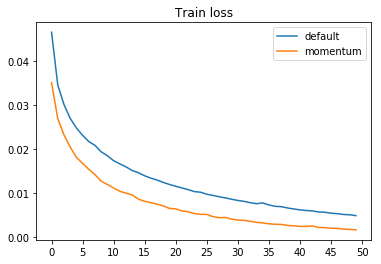

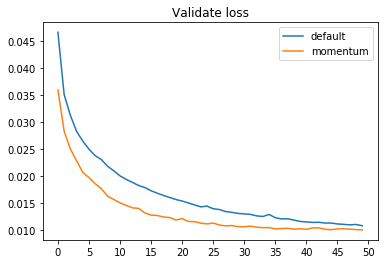

In [46]:
x = np.arange(0, epochs + 1, 5)

plt.figure(1)
plt.plot(model.loss_train_history, label = 'default')
plt.plot(model_momentum.loss_train_history, label = 'momentum')
plt.xticks(x)
plt.title('Train loss')
plt.legend()

plt.figure(2)

plt.plot(model.loss_val_history, label = 'default')
plt.plot(model_momentum.loss_val_history, label = 'momentum')
plt.xticks(x)
plt.title('Validate loss')
plt.legend()

plt.show()

Вывод: Метод стохастического градиентного спуска осуществляет коррекцию весов слоёв нейронной сети и, таким образом, обеспечивает обучение нейронной сети. При использовании информации о градиентах с предыдущих шагов обучения надежность оценки градиента возрастает, и нейронная сеть достигает большей точности (меньшего значения функции потерь) за то же число шагов.